# Tasks
1. From V_in, R, and C generate V_out
1. From V_out generate I_out
1. From V_out and I_out generate Z
1. Match Z with R and C

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [45]:
import panel as pn
import param
pn.extension(sizing_mode="stretch_width", throttled=True)

## Device and Circuit Settings

In [186]:
# Frequency & Amplitude of sin wave
freq = 2000
amp = 3.3 / 2

# Desired number of wave oscillations
cycle_num = 10

# Duration of sin wave in seconds
duration = cycle_num / freq 

# Sampling rate of device
samp_rate = freq * 100

# Input voltage wave
samp_num = int(duration * samp_rate)
t = np.linspace(0, duration, num=samp_num)
V_in = amp * np.sin(freq*(2*np.pi*t))

# Resistance in Ohms
R = 10

# Capacitance in Farads
C = 1e-6

# Ground value of circuit
V_g = 1.65

# Variable resistor of device
R_f = 0

# Impedance of RC series
Z = abs(complex(R, -1/(freq*C)))

# Output current wave
I_out = (- V_in) / Z

# Output voltage wave
V_out = V_in - I_out * R_f

In [187]:
print("Device parameters:")
print(f"{R_f=}")
print(f"{V_g=}")
print(f"{samp_rate=}")

print("\nWave parameters:")
print(f"{freq=}")
print(f"{amp=}")
print(f"{cycle_num=}")
print(f"{duration=}")

print("\nCircuit parameters:")
print(f"{R=}")
print(f"{C=}")
print(f"{Z=}")

Device parameters:
R_f=0
V_g=1.65
samp_rate=200000

Wave parameters:
freq=2000
amp=1.65
cycle_num=10
duration=0.005

Circuit parameters:
R=10
C=1e-06
Z=500.0999900019995


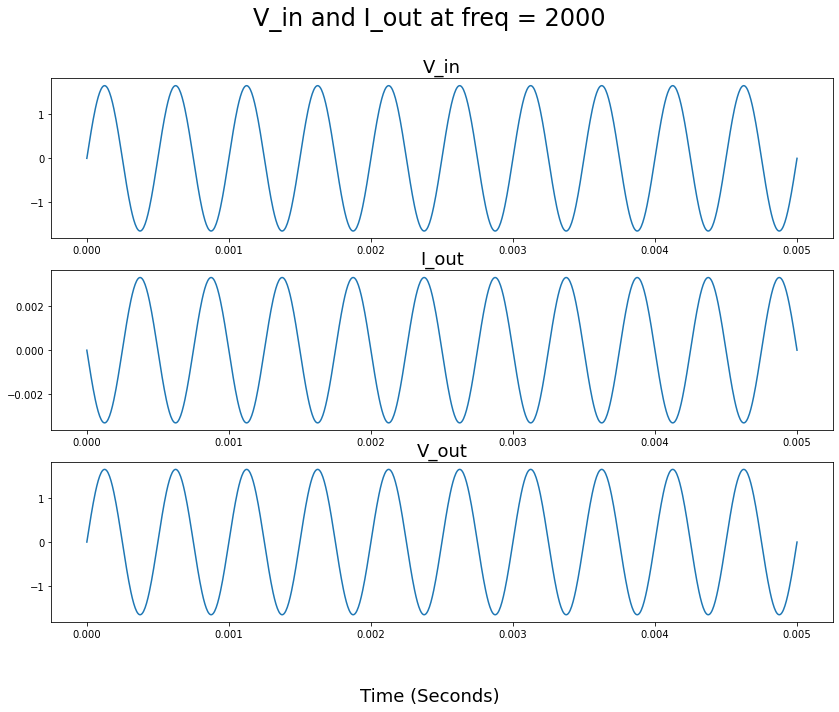

In [188]:
fig, ax = plt.subplots(3, 1, figsize=(14, 10))

fig.suptitle(f"V_in and I_out at freq = {freq}", size=24)
fig.supxlabel("Time (Seconds)", size=18)
ax[0].set_title(f"V_in", size=18)
ax[0].plot(t, V_in)

ax[1].set_title(f"I_out", size=18)
ax[1].plot(t, I_out)

ax[2].set_title(f"V_out", size=18)
ax[2].plot(t, V_out)

<StemContainer object of 3 artists>

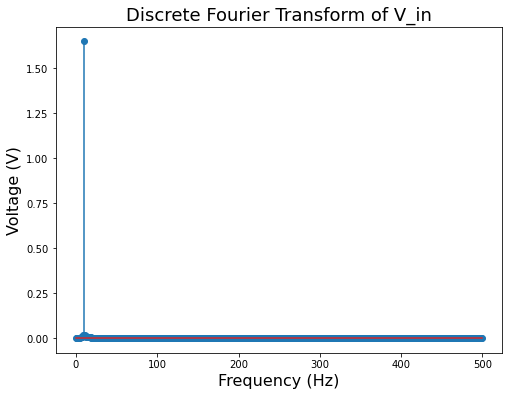

In [191]:
V_in_fft = 2 * np.abs(np.fft.fft(V_in)) / len(V_in)
V_in_fft = V_in_fft[:len(V_in_fft)//2]
V_in_amp = np.max(V_in_fft)

plt.figure(figsize=(8,6))
plt.title("Discrete Fourier Transform of V_in", size=18)
plt.xlabel("Frequency (Hz)", size=16)
plt.ylabel("Voltage (V)", size=16)
plt.stem(V_in_fft)

<StemContainer object of 3 artists>

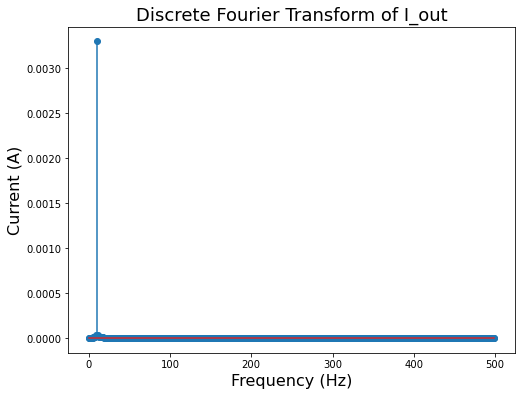

In [192]:
I_out_fft = 2 * np.abs(np.fft.fft(I_out)) / len(I_out)
I_out_fft = I_out_fft[:len(I_out_fft)//2]
I_out_amp = np.max(I_out_fft)

plt.figure(figsize=(8,6))
plt.title("Discrete Fourier Transform of I_out", size=18)
plt.xlabel("Frequency (Hz)", size=16)
plt.ylabel("Current (A)", size=16)
plt.stem(I_out_fft)

In [193]:
Z_calc = V_in_amp / I_out_amp
Z_calc

500.0999900019996

# Servable Web Application

Row(sizing_mode='stretch_width')
    [0] Column(margin=5, name='SimRC', sizing_mode='stretch_width', width=300)
        [0] StaticText(sizing_mode='stretch_width', value='<b>SimRC</b>')
        [1] IntSlider(end=10000, name='Frequency (Hz)', sizing_mode='stretch_width', start=1, value=1)
        [2] IntSlider(end=10, name='Number of Cycles', sizing_mode='stretch_width', start=1, value=1)
        [3] IntSlider(end=10000, name='Resistance (Ohms)', sizing_mode='stretch_width', start=1, value=1)
        [4] IntSlider(end=1000, name='Capacitance (nF)', sizing_mode='stretch_width', start=1, value=1)
    [1] Column(sizing_mode='stretch_width')
        [0] ParamMethod(method, sizing_mode='stretch_width')
        [1] ParamMethod(method, sizing_mode='stretch_width')
        [2] ParamMethod(method, sizing_mode='stretch_width')
        [3] ParamMethod(method, sizing_mode='stretch_width')
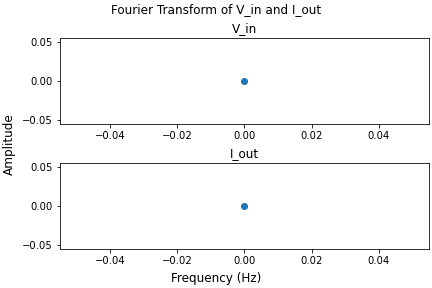
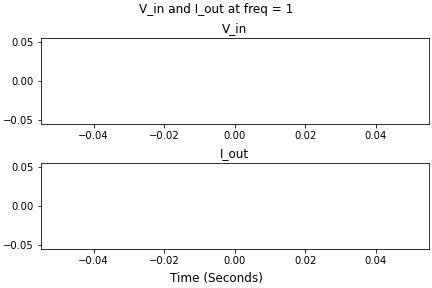

In [227]:
class SimRC(param.Parameterized):
    
    # Amplitude of Input Voltage Wave
    amp = 3.3 / 2
    
    # Frequency & Amplitude of sin wave
    freq = param.Integer(default=1, bounds=(1, 10000), label="Frequency (Hz)")

    # Desired number of wave oscillations
    cycle_num = param.Integer(default=1, bounds=(1, 10), label="Number of Cycles")

    # Resistance in Ohms
    R = param.Integer(default=1, bounds=(1, 10000), label="Resistance (Ohms)")

    # Capacitance in Nanofarads
    nC = param.Integer(default=1, bounds=(1, 1000), label="Capacitance (nF)")
    
    # Expected impedance
    Z = 0
    
    # Input Voltage Wave
    V_in = np.array([0])
    
    # Time domain values
    t = np.array([0])
    
    # Output Current Wave
    I_out = np.array([0])
    
    V_dft = I_dft = np.array([0])
    V_amp = I_amp = 0
    
    # Calculated Impedance
    Z_calc = 0
    
    @param.depends('freq', 'R', 'nC', watch=True)
    def set_Z(self):
        C = self.nC * 10e-9
        self.Z = abs(complex(self.R, -1/(self.freq*C)))
      
    @param.depends('cycle_num', 'freq', watch=True)
    def set_V_in(self):
        # Duration of sin wave in seconds
        duration = self.cycle_num / self.freq

        # Sampling rate of device
        samp_rate = self.freq * 100
        
        samp_num = int(duration * samp_rate)
        self.t = np.linspace(0, duration, num=samp_num)
        self.V_in = self.amp * np.sin(self.freq*(2*np.pi*self.t))
        
    @param.depends('V_in', watch=True)
    def set_I_out(self):
        self.I_out = (- self.V_in) / self.Z
        
    @param.depends('V_in', 'I_out', watch=True)
    def set_dfts(self):
        V_dft = 2 * np.abs(np.fft.fft(self.V_in)) / len(self.V_in)
        self.V_dft = V_dft[:len(V_dft)//2]
        self.V_amp = np.max(self.V_dft)
        
        I_dft = 2 * np.abs(np.fft.fft(self.I_out)) / len(self.I_out)
        self.I_dft = I_dft[:len(I_dft)//2]
        self.I_amp = np.max(self.I_dft)
        
        self.Z_calc = self.V_amp / self.I_amp
        

    @param.depends('Z')
    def view_Z(self):
        return pn.pane.Markdown(f"#### Expected Impedance: {self.Z}")
    
    @param.depends('V_in', 'I_out')
    def view_Z_calc(self):
        return pn.pane.Markdown(f"#### Calculated Impedance: {self.Z_calc}")
    
    @param.depends('V_in', 'I_out')
    def view_plots(self):
        fig, ax = plt.subplots(2, 1, constrained_layout=True)

        fig.suptitle(f"V_in and I_out at freq = {self.freq}")
        fig.supxlabel("Time (Seconds)")
        ax[0].set_title(f"V_in")
        ax[0].plot(self.t, self.V_in)

        ax[1].set_title(f"I_out")
        ax[1].plot(self.t, self.I_out)
        plt.close()
        return fig
    
    @param.depends('V_in', 'I_out')
    def view_dfts(self):
        fig, ax = plt.subplots(2, 1, constrained_layout=True)
        

        fig.suptitle(f"Fourier Transform of V_in and I_out")
        fig.supxlabel("Frequency (Hz)")
        fig.supylabel("Amplitude")

        ax[0].set_title(f"V_in")
        ax[0].stem(self.V_dft)

        ax[1].set_title(f"I_out")
        ax[1].stem(self.I_dft)
        plt.close()
        return fig
    
    
    

simRC = SimRC()

pn.Row(simRC.param, pn.Column(simRC.view_Z,
                              simRC.view_Z_calc,
                              simRC.view_plots,
                              simRC.view_dfts)
      )

BootstrapTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [140633111349568] Column(margin=5, name='SimRC', sizing_mode='stretch_width', width=300)
        [0] StaticText(sizing_mode='stretch_width', value='<b>SimRC</b>')
        [1] IntSlider(end=10000, name='Frequency (Hz)', sizing_mode='stretch_width', start=1, value=1)
        [2] IntSlider(end=10, name='Number of Cycles', sizing_mode='stretch_width', start=1, value=1)
        [3] IntSlider(end=10000, name='Resistance (Ohms)', sizing_mode='stretch_width', start=1, value=1)
        [4] IntSlider(end=1000, name='Capacitance (nF)', sizing_mode='stretch_width', start=1, value=1)
    [140633111347984] Card(margin=(10, 5), sizing_mode='stretch_width')
        [0] Markdown(str, margin=(10, 10), sizing_mode='stretch_width')
    [140633111350768] Card(margin=(10, 5), sizing_mode='stretch_width')
        [0] ParamMethod(method, margin=(10, 10), sizing_mode='stretch_width')
        [1] ParamMethod(method, margin=(10, 10), sizing_mode='stretch_width')
    [140633111348368] Row(sizing_mode='stretch_width')
        [0] ParamMethod(method, sizing_mode='stretch_width')
        [1] ParamMethod(method, sizing_mode='stretch_width')
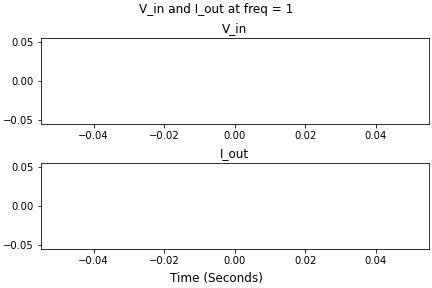
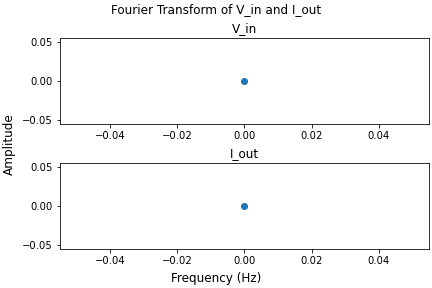

In [231]:
# Serve the web application
bootstrap = pn.template.BootstrapTemplate(title="SimRC")

bootstrap.sidebar.append(simRC.param)

message = pn.pane.Markdown("""
    # RC Circuit Impedance Software v1.0
    
    <font size=4>A Fourier Transform implementation that enables reliable impedance calculations on input voltage waveforms.</font>

    #### This software will be helpful if:
    * <font size=4>You want to simulate input voltage and output current waveform readings on a simulated RC circuit</font>
    * <font size=4>You require high-accuracy impedance readings given raw input voltage and output current data</font>

    #### Instructions
    * <font size=4>Use the sliders on the sidebar to change input voltage frequency, number of analyzed cycles,
    the resistance, and the capacitance of the RC circuit. By default, the voltage amplitude is 1.65 volts.</font>
    * <font size=4>Don't forget the capacitance is in nanofarads (nF)! You can collapse this cell using the arrow
    in the upper left corner.</font>

    #### Contact

    <font size=4>If you would like to contact me, please reach out at <nitin.nazeer@gmail.com>. I will try to best to respond to all emails.</font>

    #### License

    <font size=4>This project holds the [GNU Affero General Public License](https://www.gnu.org/licenses/agpl-3.0.en.html). All modifications must attain this license
    and remain open-source.</font>
""")

m_card = pn.Card(message)

Z_card = pn.Card(simRC.view_Z, simRC.view_Z_calc)

plots = pn.Row(
          simRC.view_plots,
          simRC.view_dfts)

bootstrap.main.append(m_card)
bootstrap.main.append(Z_card)
bootstrap.main.append(plots)

bootstrap.servable()

In [99]:
class Example(param.Parameterized):
    a = param.Integer(default=1, bounds=(1, 10), doc="A Value")
    b = param.Integer(default=2, bounds=(1, 10))
    c = param.Integer(default=3, bounds=(1, 10))
    d = param.Integer(default=4, bounds=(1, 10))
    e = None

    @param.depends('a', 'b', watch=True)
    def c_update(self):
        self.c = self.a + self.b
        
    @param.depends('a', 'c', watch=True)
    def e_update(self):
        self.e = np.arange(self.a, self.c)
        
    @param.depends('c', 'e')
    def plot(self):
        fig, ax = plt.subplots()
        ax.plot(self.e)
        plt.close()
        return fig
        

In [54]:
ex = Example()
ex.a = 5
ex.e = np.arange(ex.a, ex.c)

In [27]:
ex.c = 10
print(f"{ex.a=}")
print(f"{ex.c=}")
print(f"{ex.e=}")

ex.a=5
ex.c=10
ex.e=array([5, 6, 7, 8, 9])


Column(sizing_mode='stretch_width')
    [0] Column(margin=5, name='Example', sizing_mode='stretch_width', width=300)
        [0] StaticText(sizing_mode='stretch_width', value='<b>Example</b>')
        [1] IntSlider(end=10, name='A', sizing_mode='stretch_width', start=1, value=5)
        [2] IntSlider(end=10, name='B', sizing_mode='stretch_width', start=1, value=2)
        [3] IntSlider(end=10, name='C', sizing_mode='stretch_width', start=1, value=10)
        [4] IntSlider(end=10, name='D', sizing_mode='stretch_width', start=1, value=4)
    [1] ParamMethod(method, sizing_mode='stretch_width')
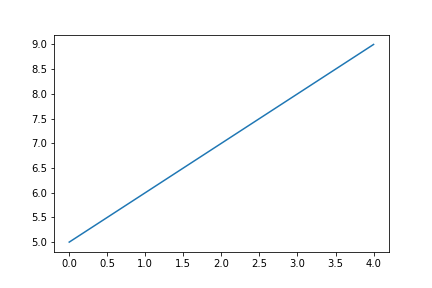

In [28]:
pn.Column(ex.param, ex.plot)